In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xeidzw4k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xeidzw4k
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import clip
import numpy as np
from PIL import Image
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt
from google.colab import files
import io
import time

In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the model
model, preprocess = clip.load("ViT-B/32", device=device)
print("Model loaded successfully!")

Using device: cuda


100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 33.3MiB/s]


Model loaded successfully!


In [26]:
def classify_garment(image, model, preprocess, device):
    """
    Classify an image into one of three garment categories.

    Args:
        image: PIL Image object
        model: CLIP model
        preprocess: CLIP preprocessing function
        device: torch device

    Returns:
        List of dictionaries with categories and confidence scores
    """
    # Converting image to RGB
    image = image.convert("RGB")

    # Preprocessing the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Defining textual descriptions for the categories
    # Using more descriptive prompts for better image-text retrieval accuracy
    categories = [
        "short sleeve clothing item",
        "long sleeve clothing item",
        "sleeveless clothing item"
    ]

    simple_categories = [
        "short sleeve",
        "long sleeve",
        "sleeveless"
    ]

    text_inputs = torch.cat([clip.tokenize(desc) for desc in categories]).to(device)

    # Calculate features

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity scores
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    print(f"similarity : {similarity}")

    # Get the similarity scores for all categories
    values, indices = similarity[0].topk(3)

    results = []
    for value, index in zip(values, indices):
        results.append({
            "category": simple_categories[index],
            "prompt description": categories[index],
            "confidence": float(value)
        })

    return results



In [27]:
def visualize_results(image, results):
    """
    Visualize the classification results with a bar chart.

    Args:
        image: PIL Image object
        results: List of dictionaries with categories and confidence scores
    """
    plt.figure(figsize=(14, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    # Displaying results as a bar chart
    plt.subplot(1, 2, 2)
    categories = [r["category"] for r in results]
    confidences = [r["confidence"] for r in results]

    bars = plt.bar(categories, confidences, color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title("Classification Results")
    plt.ylabel("Confidence Score")
    plt.ylim(0, 1.0)

    # Adding text labels
    for bar, confidence in zip(bars, confidences):
        plt.text(bar.get_x() + bar.get_width()/2, confidence + 0.01,
                f"{confidence:.2f}", ha="center")

    plt.tight_layout()
    plt.show()

    # Printing the prediction
    top_result = results[0]
    print(f"Prediction: {top_result['category']} with {top_result['confidence']:.2%} confidence")

In [28]:
# image upload
def upload_and_classify():
    print("Please upload an image of an upper-wear garment...")
    uploaded = files.upload()

    for filename, content in uploaded.items():
        print(f"Processing {filename}...")
        image = Image.open(io.BytesIO(content))

        # Classify the image
        start_time = time.time()
        results = classify_garment(image, model, preprocess, device)
        end_time = time.time()

        print(f"Classification completed in {end_time - start_time:.2f} seconds")

        # Visualize the results
        visualize_results(image, results)

Please upload an image of an upper-wear garment...


Saving MSH-1538.jpg to MSH-1538 (3).jpg
Processing MSH-1538 (3).jpg...
similarity : tensor([[0.8662, 0.0757, 0.0580]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.05 seconds


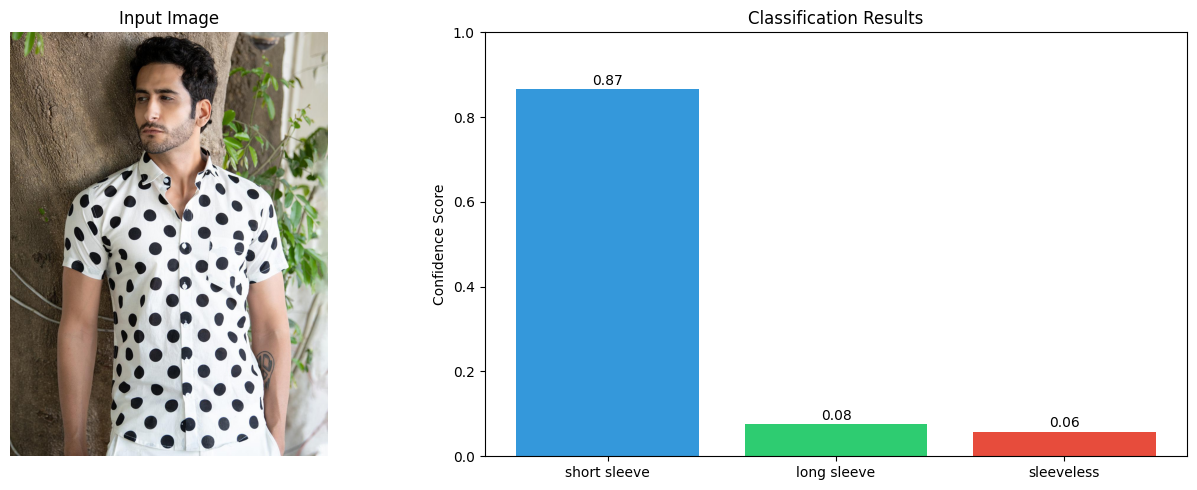

Prediction: short sleeve with 86.62% confidence


In [29]:
# Upload and classify an image
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving 61LyNGXs01L._AC_UY1100_.jpg to 61LyNGXs01L._AC_UY1100_ (1).jpg
Processing 61LyNGXs01L._AC_UY1100_ (1).jpg...
similarity : tensor([[0.8638, 0.1064, 0.0300]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


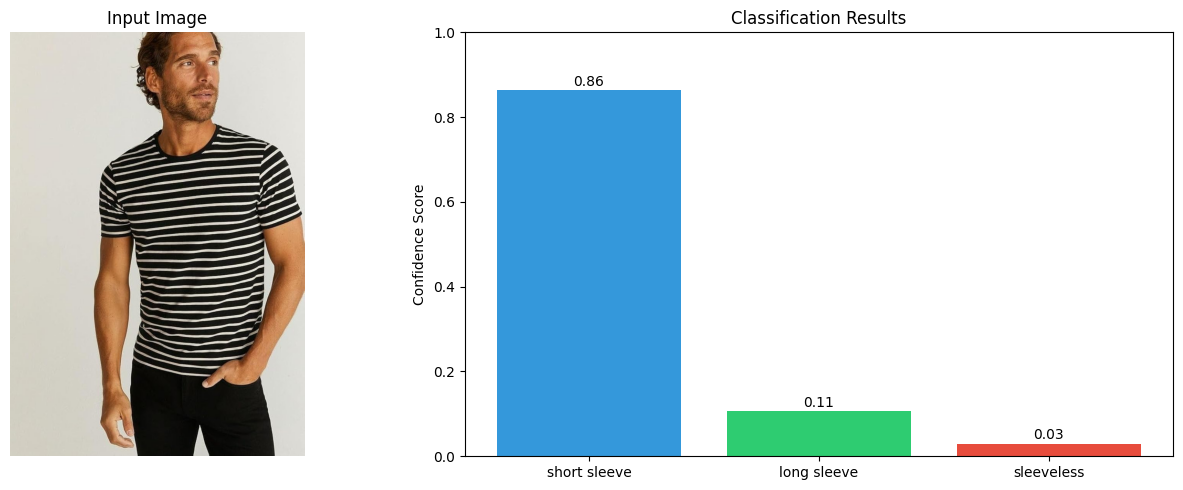

Prediction: short sleeve with 86.38% confidence


In [30]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving 1000013955430-Black-BLACK-1000013955430_01-2100.jpg to 1000013955430-Black-BLACK-1000013955430_01-2100 (1).jpg
Processing 1000013955430-Black-BLACK-1000013955430_01-2100 (1).jpg...
similarity : tensor([[0.7930, 0.1884, 0.0189]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.03 seconds


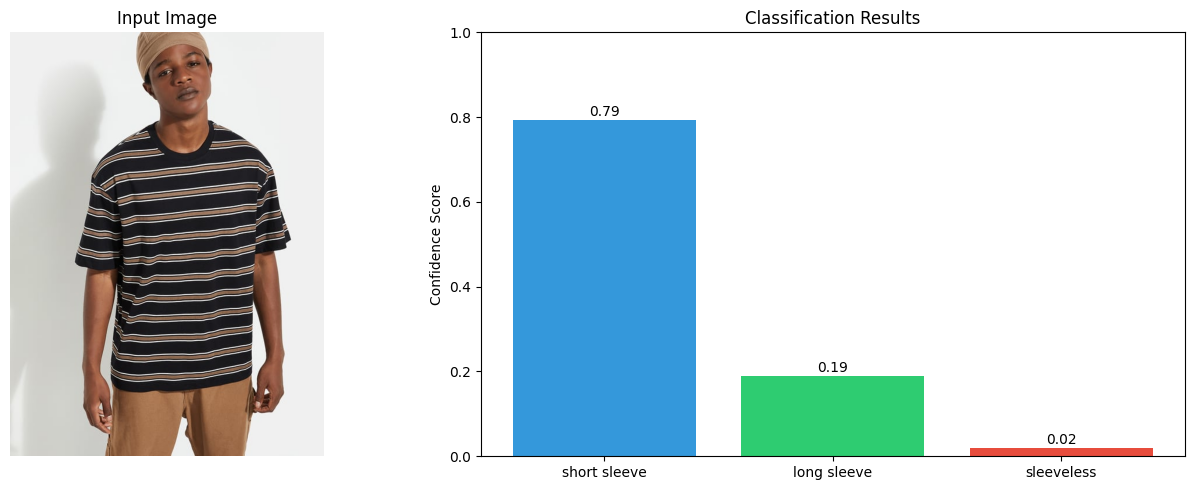

Prediction: short sleeve with 79.30% confidence


In [31]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving 71O4LIW9k1L._AC_UY1100_.jpg to 71O4LIW9k1L._AC_UY1100_.jpg
Processing 71O4LIW9k1L._AC_UY1100_.jpg...
similarity : tensor([[0.1996, 0.0590, 0.7412]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


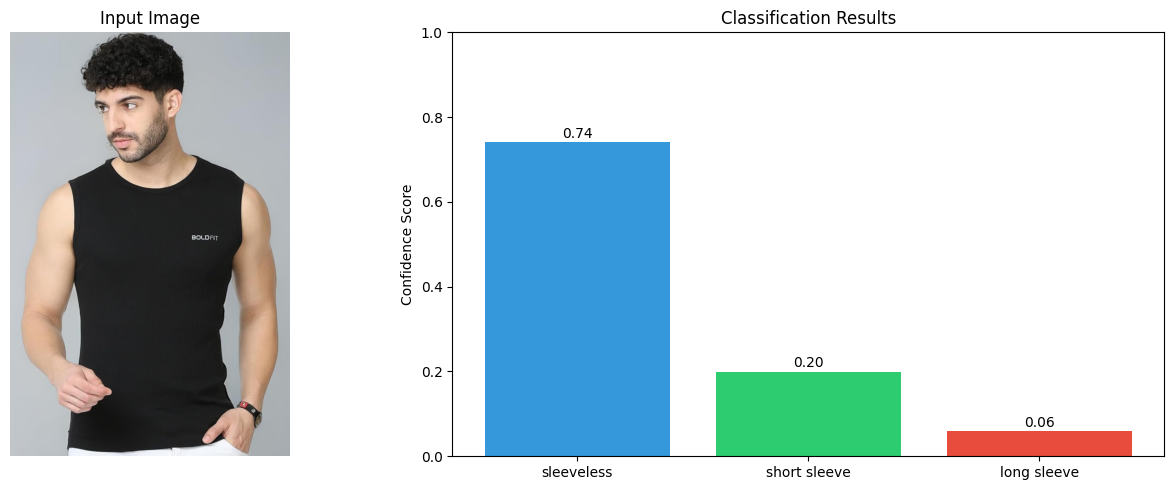

Prediction: sleeveless with 74.12% confidence


In [34]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving man_image.jpg to man_image (1).jpg
Processing man_image (1).jpg...
similarity : tensor([[0.1707, 0.7896, 0.0399]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.06 seconds


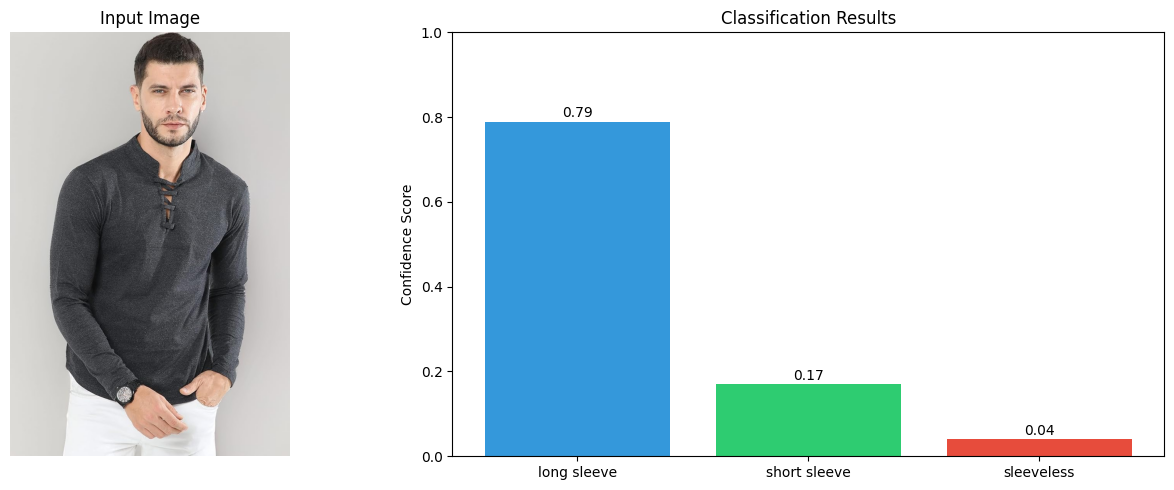

Prediction: long sleeve with 78.96% confidence


In [35]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving img__.png to img__.png
Processing img__.png...
similarity : tensor([[0.7983, 0.0472, 0.1547]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.05 seconds


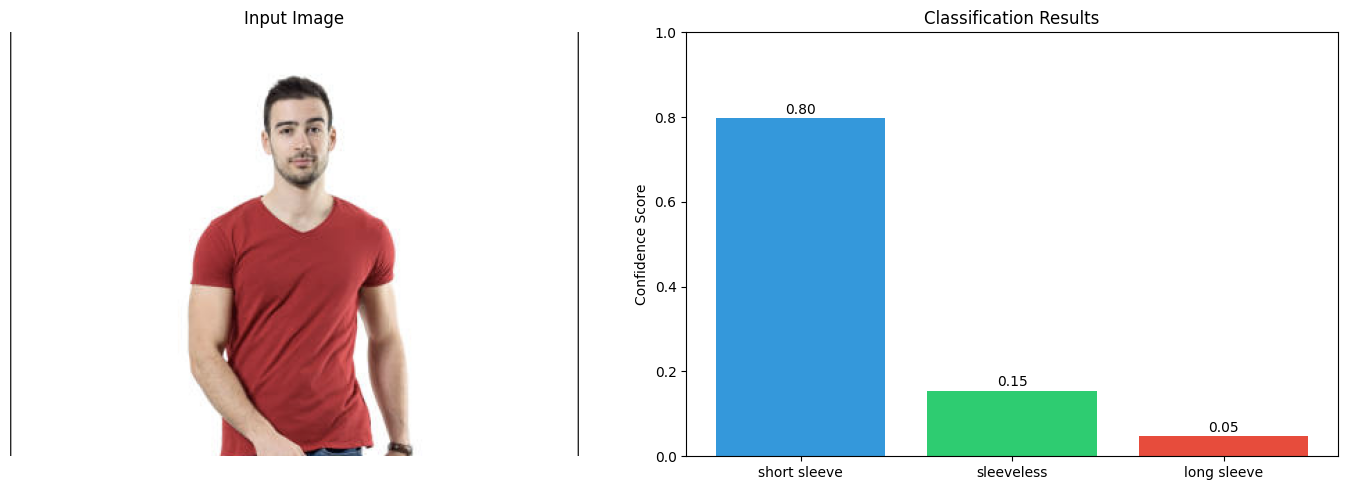

Prediction: short sleeve with 79.83% confidence


In [36]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving 71nWEGLO0vL._AC_UY1100_.jpg to 71nWEGLO0vL._AC_UY1100_ (2).jpg
Processing 71nWEGLO0vL._AC_UY1100_ (2).jpg...
similarity : tensor([[0.0672, 0.0053, 0.9277]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


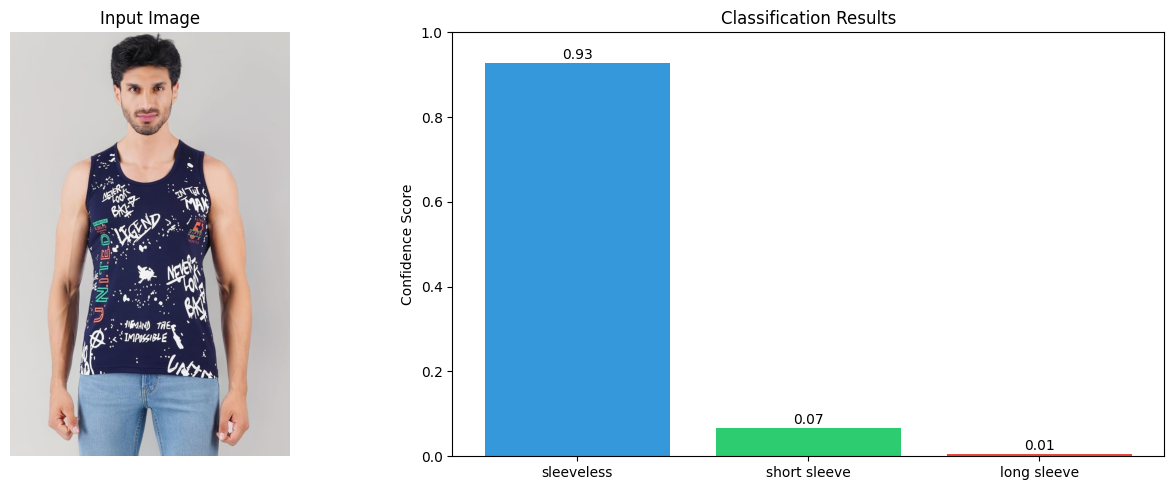

Prediction: sleeveless with 92.77% confidence


In [37]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving 5da23327-d439-4f60-a7cf-18062e24af8b1633608557979-Chemistry-Women-Tshirts-1591633608557281-1.jpg to 5da23327-d439-4f60-a7cf-18062e24af8b1633608557979-Chemistry-Women-Tshirts-1591633608557281-1.jpg
Processing 5da23327-d439-4f60-a7cf-18062e24af8b1633608557979-Chemistry-Women-Tshirts-1591633608557281-1.jpg...
similarity : tensor([[0.1263, 0.0237, 0.8501]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.05 seconds


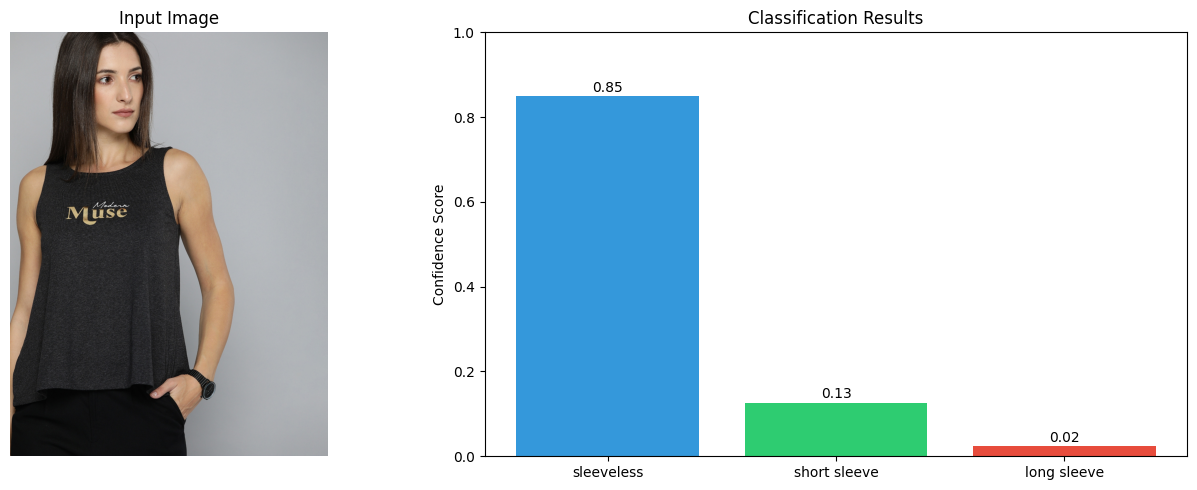

Prediction: sleeveless with 85.01% confidence


In [38]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving 71SgNkl++YL._AC_UY1100_.jpg to 71SgNkl++YL._AC_UY1100_.jpg
Processing 71SgNkl++YL._AC_UY1100_.jpg...
similarity : tensor([[0.0445, 0.9365, 0.0191]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.04 seconds


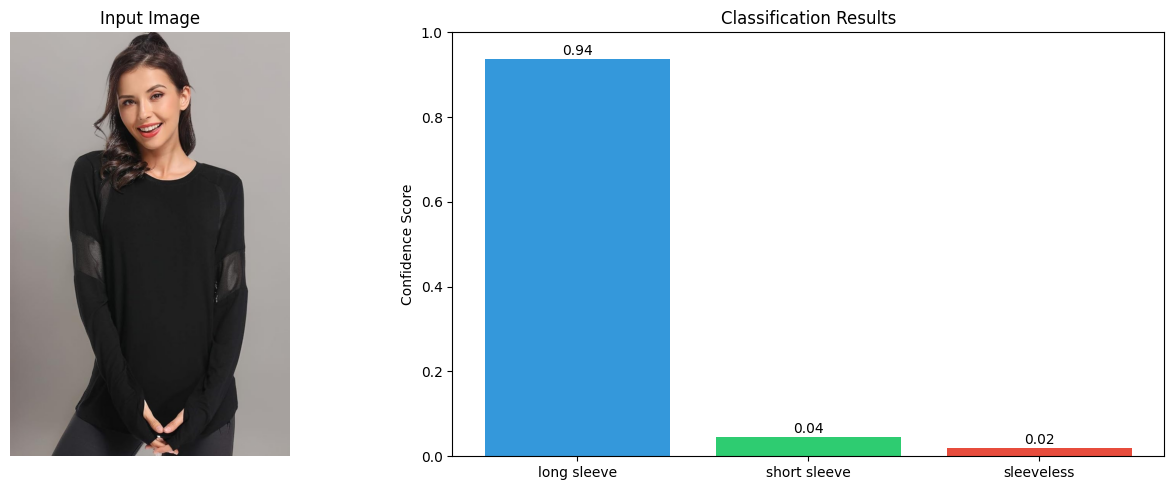

Prediction: long sleeve with 93.65% confidence


In [39]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving NFSTGreenTea2.jpg to NFSTGreenTea2.jpg
Processing NFSTGreenTea2.jpg...
similarity : tensor([[0.0259, 0.9731, 0.0011]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.06 seconds


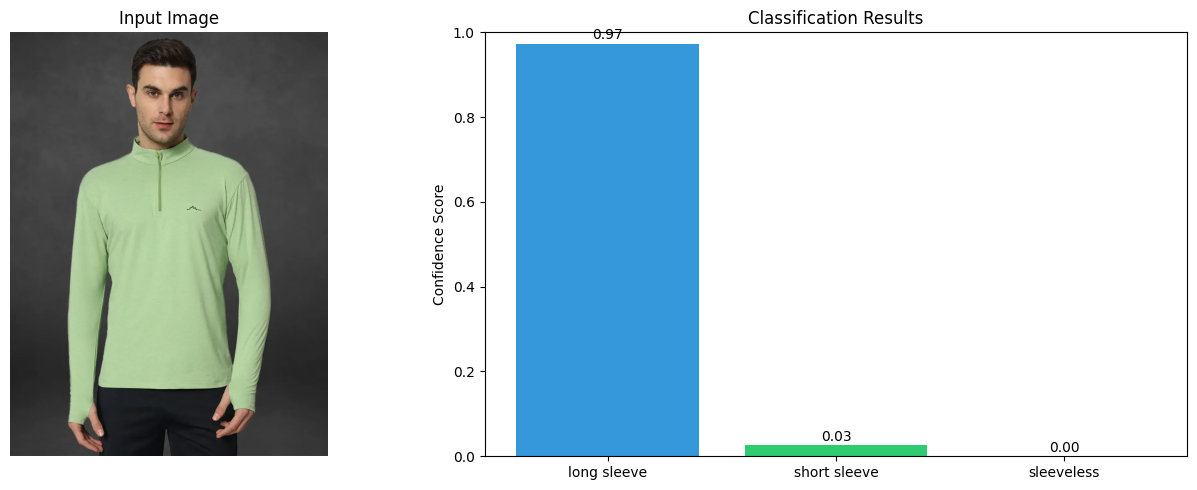

Prediction: long sleeve with 97.31% confidence


In [41]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving NFSTGreenTea1.webp to NFSTGreenTea1 (1).webp
Processing NFSTGreenTea1 (1).webp...
similarity : tensor([[0.1641, 0.8335, 0.0025]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.05 seconds


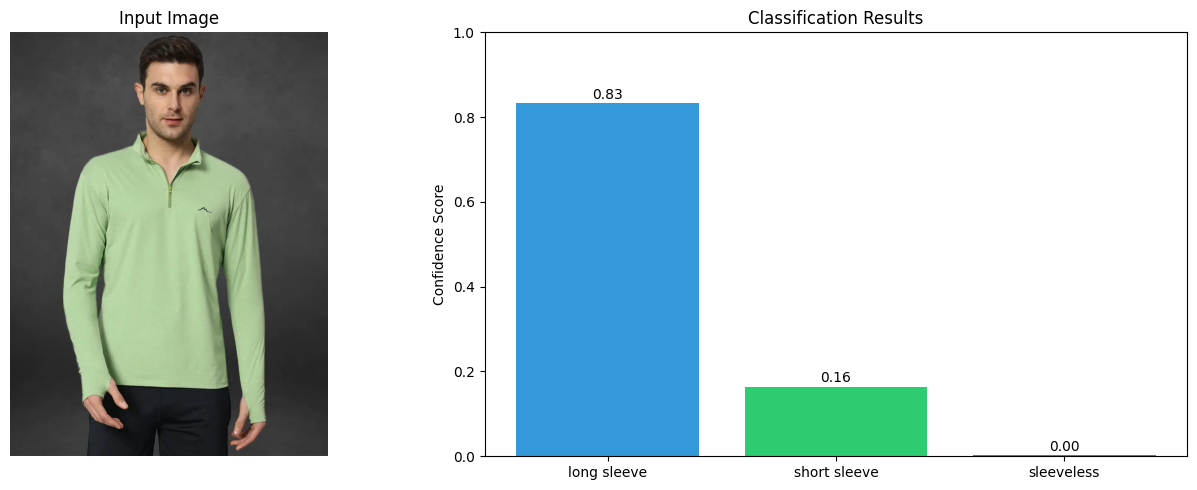

Prediction: long sleeve with 83.35% confidence


In [43]:
# accuracy drop when using .webp format
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving M-01_1.jpg to M-01_1.jpg
Processing M-01_1.jpg...
similarity : tensor([[0.1835, 0.7847, 0.0319]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.06 seconds


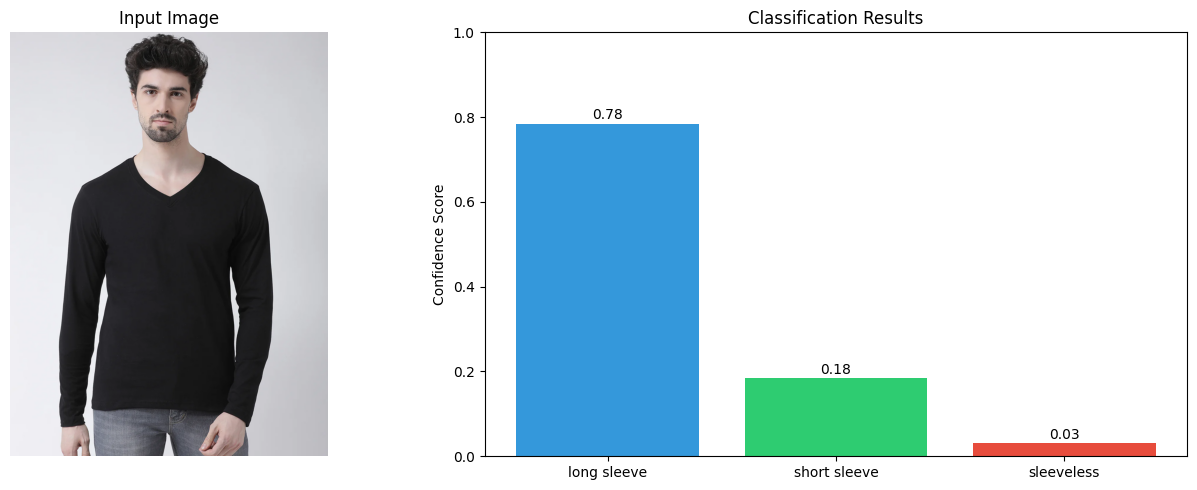

Prediction: long sleeve with 78.47% confidence


In [44]:
upload_and_classify()

Please upload an image of an upper-wear garment...


Saving 224066148-2-38_1.jpg.jpg to 224066148-2-38_1.jpg.jpg
Processing 224066148-2-38_1.jpg.jpg...
similarity : tensor([[0.3247, 0.6660, 0.0091]], device='cuda:0', dtype=torch.float16)
Classification completed in 0.07 seconds


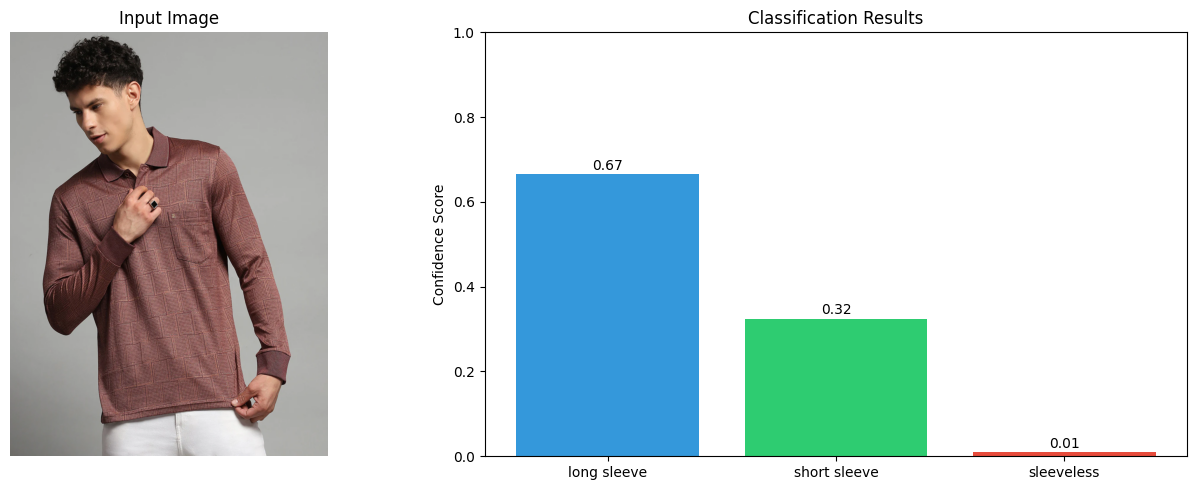

Prediction: long sleeve with 66.60% confidence


In [45]:
upload_and_classify()